# Load and imports

In [1]:
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h2o

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pickle
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

df05ht = pd.read_csv('data_live_scores.csv', encoding='utf-8')
print(df05ht.shape)

(434237, 27)


In [2]:
# # diminuindo a janela de tempo para 5 minutos
# # os ultimos 5 minutos antes do evento são iguais a 1

# data_with_result_1 = df05ht[df05ht['result'] == 1]
# data_with_result_0 = df05ht[df05ht['result'] == 0]

# # Grouping by 'match_id' and getting the last 5 entries for each group
# grouped_data_last = data_with_result_1.groupby('match_id').tail(5)
# grouped_data_first = data_with_result_1.groupby('match_id').head(5)

# grouped_data_first['result'] = 0

# filtered_data = pd.concat([data_with_result_0, grouped_data_first, grouped_data_last], axis=0)
# df05ht = filtered_data
# # filtered_data[filtered_data['match_id'] == '2020-01-25-Esporte Clube Água Santa-Grêmio Novorizontino']

In [3]:
df05ht.reset_index(inplace=True, drop=True)

In [4]:
date_object = pd.to_datetime(df05ht['date'], format='%Y-%m-%d')

min_date = date_object.min()
max_date = date_object.max()

print("Os dados vão de {} até {}".format(min_date, max_date))

Os dados vão de 2020-01-08 00:00:00 até 2023-11-20 00:00:00


In [5]:
df05ht.columns

Index(['date', 'minute', 'homeTeam', 'awayTeam', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'passes_home', 'passes_away',
       'fouls_c_home', 'fouls_c_away', 'fouls_won_home', 'fouls_won_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id'],
      dtype='object')

# Analisando e tratando os dados

## Limpeza

In [6]:
df = df05ht.copy()
print(f'Dimensão do DataFrame antes remoção: {df05ht.shape}')
print(f'Valores únicos de minutos antes da conversão: {df05ht.minute.unique()} \n')
registros_duplicados = len(df05ht[df05ht.duplicated()])
print(f'Registros duplicados: {registros_duplicados}')
df.drop_duplicates(keep='last', inplace=True)

registros_nulos = df.isnull().sum().sum()
print(f'Registros nulos: {registros_nulos}\n')
df.dropna(inplace=True)

# Convertendo os minutos para inteiros
df['minute_converted'] = df05ht['minute'].str.extract('(\d+)').astype(int)

# Removendo os minutos iguais a 0
df = df[df['minute_converted'] != 0]

# Identificando e removendo IDs de jogos com minutos fora do intervalo
invalid_ids = df[df['minute_converted'] > 45]['match_id'].unique()
df = df[~df['match_id'].isin(invalid_ids)]

# Removendo a coluna 'minute_converted' e salvando o DataFrame com o formato original (sem os minutos convertidos)
# df.drop(columns=['minute_converted']).drop_duplicates().to_csv('data_teste.csv', index=False, encoding='utf-8')

df['minute'] = df['minute_converted']
df.drop(columns=['minute_converted'], inplace=True)
print(f'Jogos que serão retirados: {len(invalid_ids)}\n')

df.dropna(inplace=True)

print(f'Dimensão do DataFrame após remoção: {df.shape}')
print(f'Total de registros retirados: {df05ht.shape[0] - df.shape[0]}')

Dimensão do DataFrame antes remoção: (434237, 27)
Valores únicos de minutos antes da conversão: ['10:26' '11:06' '11:45' ... '41:07' '22:60' '17:38'] 



Registros duplicados: 0
Registros nulos: 0

Jogos que serão retirados: 0

Dimensão do DataFrame após remoção: (434237, 27)
Total de registros retirados: 0


In [7]:
# datas com minutos inválidos
datas = df05ht[df05ht['match_id'].isin(invalid_ids)]['date'].unique()
for data in datas:
    print(f"'{data}',", end=' ')

## Seleção de Ligas, Cálculo de Posse de Bola e Limpeza do DataFrame

In [8]:
# Calculando o tempo de posse de bola
total_passes = df['passes_away'] + df['passes_home']
df['possessiontime_away'] = round((df['passes_away'] / total_passes) * 100)
df['possessiontime_home'] = round((df['passes_home'] / total_passes) * 100)

df['possessiontime_home'].fillna(method='bfill', inplace=True)
df['possessiontime_away'].fillna(method='bfill', inplace=True)

print("\nDados de posse de bola:\n", df[['possessiontime_away', 'possessiontime_home']].head())

# Renomeando colunas
new_column_names = {'fouls_won_away': 'fouls_away', 'fouls_won_home': 'fouls_home'}
df.rename(columns=new_column_names, inplace=True)
print("\nColunas renomeadas:\n", df.columns)

# Removendo colunas desnecessárias e limpando o DataFrame
columns_to_drop = ["date", 'passes_home', 'passes_away', 'fouls_c_home', 'fouls_c_away']
df.drop(columns=columns_to_drop, inplace=True)
print("\nDataFrame após remover colunas:\n", df.columns)

df.reset_index(drop=True, inplace=True)
print(f'Dimensão do DataFrame após modificações: {df.shape}')
df.isnull().sum()


Dados de posse de bola:
    possessiontime_away  possessiontime_home
0                 13.0                 87.0
1                 15.0                 85.0
2                 15.0                 85.0
3                 15.0                 85.0
4                 15.0                 85.0

Colunas renomeadas:
 Index(['date', 'minute', 'homeTeam', 'awayTeam', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'passes_home', 'passes_away',
       'fouls_c_home', 'fouls_c_away', 'fouls_home', 'fouls_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id', 'possessiontime_away', 'possessiontime_home'],
      dtype='object')



DataFrame após remover colunas:
 Index(['minute', 'homeTeam', 'awayTeam', 'league', 'corners_home',
       'corners_away', 'redcards_home', 'redcards_away', 'shotsOffgoal_home',
       'shotsOffgoal_away', 'shotsOngoal_home', 'shotsOngoal_away',
       'yellowcards_home', 'yellowcards_away', 'fouls_home', 'fouls_away',
       'offsides_home', 'offsides_away', 'tackles_home', 'tackles_away',
       'result', 'match_id', 'possessiontime_away', 'possessiontime_home'],
      dtype='object')
Dimensão do DataFrame após modificações: (434237, 24)


minute                 0
homeTeam               0
awayTeam               0
league                 0
corners_home           0
corners_away           0
redcards_home          0
redcards_away          0
shotsOffgoal_home      0
shotsOffgoal_away      0
shotsOngoal_home       0
shotsOngoal_away       0
yellowcards_home       0
yellowcards_away       0
fouls_home             0
fouls_away             0
offsides_home          0
offsides_away          0
tackles_home           0
tackles_away           0
result                 0
match_id               0
possessiontime_away    0
possessiontime_home    0
dtype: int64

## Tratando o formato das ligas para ligas existentes 

In [9]:
# Obtendo ligas únicas
leagues_opta = df['league'].unique()
print("Ligas únicas:", leagues_opta)

# Iterando através das ligas únicas
for league in leagues_opta:
    print("Liga atual:", league)

# Mapeamento de nomes de ligas
name_mapping = {
    'England - Premier League': 'England - Premier League',
    'Germany - Bundesliga': 'Germany - Bundesliga',
    'Spain - Primera División': 'Spain - La Liga',
    'France - Ligue 1': 'France - Ligue 1',
    'Italy - Serie A': 'Italy - Serie A',
    'USA - MLS': 'USA - Major League Soccer',
    'Brazil - Serie A': 'Brazil - Serie A',
    'Netherlands - Eredivisie': 'Netherlands - Eredivisie',
    'England - Championship': 'England - Championship',
    'Portugal - Primeira Liga': 'Portugal - Liga Portugal',
    'Romania - Liga I': 'Romania - Liga 1',
    "World - FIFA Women's World Cup": 'World - World Cup Women',
    'England - League One': 'England - League One',
    'England - League Two': 'England - League Two',
    'Europe - UEFA Europa Conference League': 'Europe - Europa Conference League',
    'England - League Cup': 'England - Carabao Cup',
    'Europe - UEFA Super Cup': 'Europe - Uefa Super Cup',
    'Europe - UEFA Champions League': 'Europe - Champions League',
    'Germany - DFB Pokal': 'Germany - DFB Pokal',
    'Italy - Coppa Italia': 'Italy - Coppa Italia',
    'Scotland - Premiership': 'Scotland - Premiership',
    'Germany - Super Cup': 'Germany - Super Cup',
    'South America - CONMEBOL Libertadores': 'South America - Copa Libertadores',
    'England - Community Shield': 'England - Community Shield',
    'N/C America - Concacaf Gold Cup': 'World - CONCACAF Gold Cup',
    'Europe - UEFA U21 Championship': 'Europe - Euro U21',
    'Australia - A-League Men': 'Australia - A-League',
    'Portugal - Play-offs 1/2': 'Portugal - Primeira Liga - Play-offs',
    'Europe - UEFA European Championship Qualifiers': 'Europe - Euro Qualification',
    'Germany - Play-offs 1/2': 'Germany - Bundesliga Play-offs',
    'Europe - UEFA Nations League': 'Europe - UEFA Nations League',
    'Europe - UEFA Europa League': 'Europe - Europa League',
    'England - FA Cup': 'England - FA Cup',
    'Spain - Copa del Rey': 'Spain - Copa Del Rey',
    'World - FIFA World Cup': 'World - FIFA World Cup',
    'France - Coupe de France': 'France - Coupe de France',
    'Spain - Super Cup': 'Spain - Super Cup',
    'Italy - Super Cup': 'Italy - Super Cup',
    'World - FIFA Club World Cup': 'World - FIFA Club World Cup',
    'Argentina - Liga Profesional Argentina': "Argentina - Superliga",
    'Brazil - Paulista A1': 'Brazil - Paulista A1',
    'Brazil - Copa do Brasil': 'Brazil - Copa Do Brasil',
    'Denmark - Superliga':'Denmark - Superliga',
    'Mexico - Liga MX': 'Mexico - Liga MX',
    'Greece - Super League 1': 'Greece - Super League',
    'Asia - AFC Champions League': 'Asia - AFC Champions League', 
    'South America - CONMEBOL Sudamericana': 'South America - Copa Sudamericana', 
    'Spain - Segunda División': 'Spain - La Liga 2',
    'Saudi Arabia - Saudi League': 'Saudi Arabia - Pro League',
    'Italy - Serie B': 'Italy - Serie B',
    'Japan - J1 League': 'Japan - J-League',
    'South America - CONMEBOL World Cup Qualifiers': 'World - WC Qualification South America',
    'Europe - UEFA World Cup Qualifiers': 'Europe - WC Qualification Europe', 
    "Europe - UEFA Women's Championship": "Europe - UEFA Women's EURO",
    "France - Trophée des Champions": 'France - Super Cup',
    'Brazil - Supercopa do Brasil': 'Brazil - Supercopa do Brasil',
    'South America - CONMEBOL Recopa': 'South America - Recopa Sudamericana',
    'Europe - UEFA European Championship': 'Europe - European Championship', 
    'N/C America - Leagues Cup': 'North & Central America - Leagues Cup',
    'South America - CONMEBOL Copa America': 'South America - Copa America',

}
print("\nTamanho do mapeamento de nomes de ligas:", len(name_mapping))

# Verificando o número de ligas únicas
print("Número de ligas únicas:", len(leagues_opta))
print("Número de ligas únicas após o mapeamento:", len(name_mapping))

# Atualizando os nomes das ligas no DataFrame
df['league'] = df['league'].replace(name_mapping)

# Verificando algumas linhas do DataFrame após a atualização dos nomes das ligas
# print("\nDataFrame após atualizar os nomes das ligas:\n", df['league'].unique())
for league in df['league'].unique():
    print("Liga atual no dataframe:", league)

Ligas únicas: ['South America - CONMEBOL Libertadores' 'Brazil - Paulista A1'
 'Asia - AFC Champions League' 'Brazil - Supercopa do Brasil'
 'Japan - J1 League' 'South America - CONMEBOL Sudamericana' 'USA - MLS'
 'Brazil - Copa do Brasil' 'Germany - Play-offs 1/2' 'Mexico - Liga MX'
 'Scotland - Premiership' 'Brazil - Serie A' 'France - Ligue 1'
 'Europe - UEFA Champions League' 'England - League Cup'
 'Europe - UEFA Nations League' 'England - Premier League'
 'Germany - Bundesliga' 'Italy - Serie A' 'Italy - Serie B'
 'Netherlands - Eredivisie' 'England - Championship'
 'Spain - Primera División' 'Greece - Super League 1'
 'South America - CONMEBOL World Cup Qualifiers' 'England - League One'
 'England - League Two' 'Europe - UEFA Europa League'
 'Argentina - Liga Profesional Argentina' 'England - FA Cup'
 'Australia - A-League Men' 'Europe - UEFA European Championship'
 'N/C America - Concacaf Gold Cup' 'Europe - UEFA World Cup Qualifiers'
 'Denmark - Superliga' 'Saudi Arabia - Saud

## Balanceamento de Dados e Visualização da Distribuição de Resultados por Liga

Contando partidas por time...
Total de partidas: 11842

Filtrando dados de ligas...
Dados filtrados:

league
England - Premier League             36571
USA - Major League Soccer            34859
Brazil - Serie A                     22319
Argentina - Superliga                21776
Spain - La Liga                      19602
Germany - Bundesliga                 16953
England - Championship               16928
England - League Two                 16116
Italy - Serie A                      14737
England - League One                 14667
South America - Copa Libertadores    13764
France - Ligue 1                     13218
Europe - Champions League            13055
Spain - La Liga 2                    11649
Mexico - Liga MX                     11047
Japan - J-League                     10925
Italy - Serie B                      10458
Saudi Arabia - Pro League             9511
Netherlands - Eredivisie              9188
Europe - UEFA Nations League          8784
Portugal - Liga Portugal       

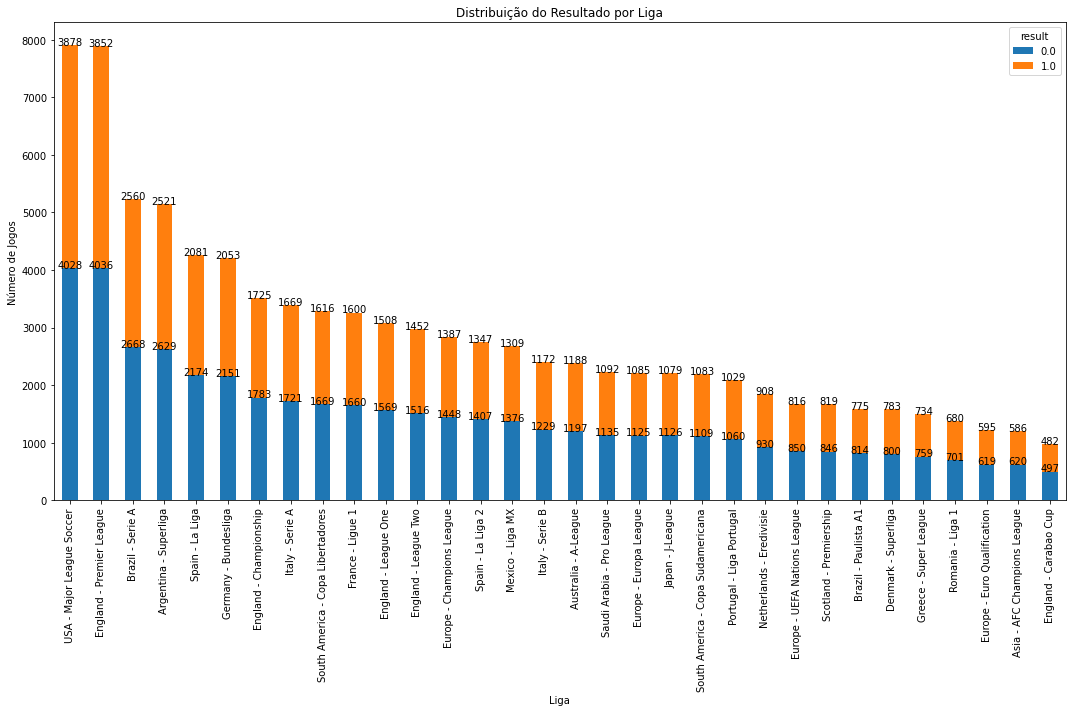

<Figure size 432x288 with 0 Axes>

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def filter_leagues(df, league_col, matches, min_matches=100):
    """Filtra ligas com base no número de partidas e na diversidade de resultados."""
    league_game_counts = df.groupby(league_col)[matches].nunique()
    leagues_filtered = league_game_counts[league_game_counts >= min_matches].index
    filtered_data = df[df[league_col].isin(leagues_filtered)]
    return filtered_data

def balance_data(df, league_col='league', result_col='result'):
    leagues = df[league_col].unique()
    balanced_dfs = []
    for league in leagues:
        league_df = df[df[league_col] == league]
        result_counts = league_df[result_col].value_counts()
        min_count = result_counts.min()
        balanced_league_df = pd.concat([
            league_df[league_df[result_col] == 0].sample(min_count, random_state=42),
            league_df[league_df[result_col] == 1].sample(min_count, random_state=42)
        ])
        balanced_dfs.append(balanced_league_df)
    balanced_data = pd.concat(balanced_dfs).reset_index(drop=True)
    return balanced_data

print("Contando partidas por time...")
total_matches_per_team = len(df['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

print("\nFiltrando dados de ligas...")
filtered_data = filter_leagues(df, 'league', 'match_id')
print("Dados filtrados:\n")
print(filtered_data['league'].value_counts())

print("\nBalanceando dados...")
balanced_data = balance_data(filtered_data)
print("Dados balanceados:\n")
print(balanced_data['result'].value_counts())

balanced_data.drop_duplicates(keep='last', inplace=True)
balanced_data.dropna(inplace=True)

league_distribution = balanced_data.groupby(['league', 'result']).size().unstack()
sorted_leagues = league_distribution.sum(axis=1).sort_values(ascending=False).head(100).index

print("Contando partidas depois dos filtros...")
total_matches_per_team = len(balanced_data['match_id'].unique())
print("Total de partidas:", total_matches_per_team)

plt.figure(figsize=(15, 10))
ax = league_distribution.loc[sorted_leagues].plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Distribuição do Resultado por Liga')
plt.ylabel('Número de Jogos')
plt.xlabel('Liga')
plt.tight_layout()
plt.xticks(rotation=90)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0f}', (x + width/2, y + height), ha='center')

plt.show()
plt.clf()  

In [11]:
balanced_data.to_csv("data_balanced.csv", index=False, encoding='utf-8')